In [1]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [54]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import sklearn
import pandas as pd
from mixture_models import GMCM, GMC
import utils as utl

# Iris dataset (n_dims=4, n_samps=150)

Number of samples = 150, Number of dimensions = 4
Learning Marginals
Marginals learnt in 2.06 s.
@ Iter:0,                         Training error: -11.1,                         Validation error: nan,                         Time Elapsed: 6.1 s
@ Iter:1000,                         Training error: -13.3,                         Validation error: nan,                         Time Elapsed: 12.3 s
@ Iter:2000,                         Training error: -13.3,                         Validation error: nan,                         Time Elapsed: 19.0 s
@ Iter:3000,                         Training error: -13.2,                         Validation error: nan,                         Time Elapsed: 25.7 s
@ Iter:4000,                         Training error: -13.5,                         Validation error: nan,                         Time Elapsed: 32.0 s


Text(0, 0.5, 'neg. log-likelihood')

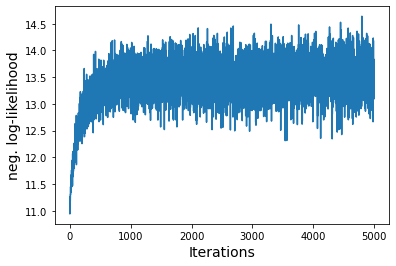

In [117]:
# Loading Iris data set from scikit learn data libraray
from sklearn.datasets import load_iris
data=load_iris().data.astype('float32')
nsamps,ndims = data.shape

# Defining a preprocessing bijective transform (eg, log transform in this case)
# orignal data x, define data transform y=log(x-min_val) (min val is conservatively obtained lower bound along each dimension)
# this "OPTIONAL" bijective transformation can be chained to the GMCM bijections (at the end). It improves the learning of marginals by mitigating heavy tails
min_val = (np.min(data)-3*np.std(data)).astype('float32')
log_transform = tfb.Chain([tfb.Shift(shift=min_val),tfb.Exp()])

# splitting the data into training, testing and validation sets
data_trn,data_vld,data_tst = utl.splitData(data)

nsamps,ndims = data.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

# Initialing GMCM object
gmcm_obj=GMCM(ndims, data_transform=log_transform)
# Train GMCM (with 2 components)
nll_train,nll_vld,_=gmcm_obj.fit_dist_IFM(data_trn,
                                    n_comps=2,
                                    batch_size=10,
                                    max_iters=5000,
                                    regularize=True,
                                    print_interval=1000)

# Plot log-likelihood
plt.plot(-nll_train)
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('neg. log-likelihood',fontsize=14)

In [118]:
# Learning GMM (with the same number of components) using scikit learn libraray
gmm_obj=utl.GMM_best_fit(data_trn,
                         min_ncomp=2,
                         max_ncomp=2,
                         max_iter=10000, 
                         print_info=True)

Fittng a GMM on samples with 2 components: BIC=381.085427


In [128]:
# Getting the marginals (of GMCM and GMM) along any two dimensions
dim1,dim2=0,1

# GMCM marginal
gmcm_marg=gmcm_obj.get_marginal([dim1,dim2])

# GMM marginal
gmm_marg_mus=gmm_obj.means_[:,[dim1,dim2]].astype('float32')
gmm_marg_covs=tf.gather(tf.gather(gmm_obj.covariances_.astype('float32'),[dim1,dim2],axis=1),[dim1,dim2],axis=2)
gmm_marg_alphas=gmm_obj.weights_.astype('float32')
gmm_marg=tfd.MixtureSameFamily(tfd.Categorical(probs=gmm_marg_alphas),
                               tfd.MultivariateNormalFullCovariance(loc=gmm_marg_mus,
                                                                    covariance_matrix=gmm_marg_covs))

# Plotting 2-d density contours of the GMCM and GMM 

Text(0.5, 1.0, 'GMM density contours (Iris)')

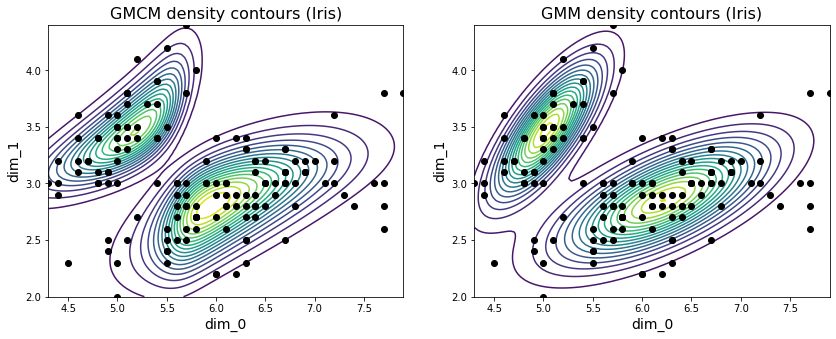

In [129]:
# Plotting the density contours along the two specified dimensions
fig,ax=plt.subplots(1,2,figsize=(14,5))

plt.sca(ax[0])
utl.plotDensityContours(data,gmcm_marg.distribution.log_prob,dim1,dim2)
ax[0].set_title('GMCM density contours (Iris)',fontsize=16)

plt.sca(ax[1])
utl.plotDensityContours(data,gmm_marg.log_prob,dim1,dim2)
ax[1].set_title('GMM density contours (Iris)',fontsize=16)


#  Wine dataset (n_dims=13, n_samps=178)

Number of samples = 178, Number of dimensions = 13
Learning Marginals
Marginals learnt in 6.65 s.
@ Iter:0,                         Training error: -33.8,                         Validation error: nan,                         Time Elapsed: 6.7 s
@ Iter:500,                         Training error: -39.9,                         Validation error: nan,                         Time Elapsed: 11.5 s
@ Iter:1000,                         Training error: -41.3,                         Validation error: nan,                         Time Elapsed: 16.0 s
@ Iter:1500,                         Training error: -42.3,                         Validation error: nan,                         Time Elapsed: 20.6 s
@ Iter:2000,                         Training error: -42.1,                         Validation error: nan,                         Time Elapsed: 25.3 s
@ Iter:2500,                         Training error: -42.2,                         Validation error: nan,                         Time Elapsed: 29

Text(0, 0.5, 'neg. log-likelihood')

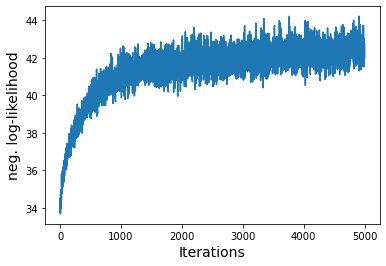

In [109]:
# Loading Iris data set from scikit learn data libraray
from sklearn.datasets import load_wine
data=load_wine().data.astype('float32')
nsamps,ndims = data.shape


# splitting the data into training, testing and validation sets
data_trn,data_vld,data_tst = utl.splitData(data)

nsamps,ndims = data.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

# Initialing GMCM object
gmcm_obj=GMCM(ndims) # no data preprocessing this time

# Train GMCM (with 3 components)
nll_train,nll_vld,_=gmcm_obj.fit_dist_IFM(data_trn,
                                    n_comps=3,
                                    batch_size=20,
                                    max_iters=5000,
                                    regularize=True,
                                    print_interval=1000)

# Plot log-likelihood
plt.plot(-nll_train)
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('neg. log-likelihood',fontsize=14)

In [110]:
# Learning GMM (with the same number of components) using scikit learn libraray
gmm_obj=utl.GMM_best_fit(data_trn,
                         min_ncomp=3,
                         max_ncomp=3,
                         max_iter=10000, 
                         print_info=True)

Fittng a GMM on samples with 3 components: BIC=5482.451234


In [115]:
# Getting the marginals (of GMCM and GMM) along any two dimensions
dim1,dim2=1,2

# GMCM marginal
gmcm_marg=gmcm_obj.get_marginal([dim1,dim2])

# GMM marginal
gmm_marg_mus=gmm_obj.means_[:,[dim1,dim2]].astype('float32')
gmm_marg_covs=tf.gather(tf.gather(gmm_obj.covariances_.astype('float32'),[dim1,dim2],axis=1),[dim1,dim2],axis=2)
gmm_marg_alphas=gmm_obj.weights_.astype('float32')
gmm_marg=tfd.MixtureSameFamily(tfd.Categorical(probs=gmm_marg_alphas),
                               tfd.MultivariateNormalFullCovariance(loc=gmm_marg_mus,
                                                                    covariance_matrix=gmm_marg_covs))

# Plotting 2-d density contours of the GMCM and GMM 

Text(0.5, 1.0, 'GMM density contours (Wine)')

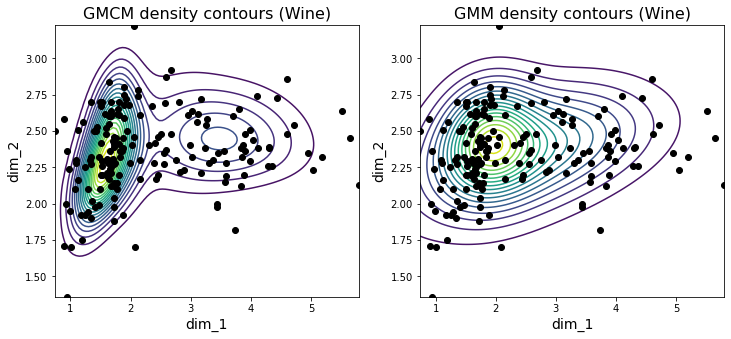

In [116]:
# Plotting the density contours along the two specified dimensions
fig,ax=plt.subplots(1,2,figsize=(12,5))

plt.sca(ax[0])
utl.plotDensityContours(data,gmcm_marg.distribution.log_prob,dim1,dim2)
ax[0].set_title('GMCM density contours (Wine)',fontsize=16)

plt.sca(ax[1])
utl.plotDensityContours(data,gmm_marg.log_prob,dim1,dim2)
ax[1].set_title('GMM density contours (Wine)',fontsize=16)
